In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from qmplot import manhattanplot

In [2]:
pathToRegenieData="/mnt/disks/emerge_data/regenie_analysis/"

In [29]:
centers = ["mayo", "marshfield", "northwestern", "vanderbilt", "group", "geisinger", "mount"]
centerPhenoData = {}
for center in centers:
    centerPhenoData[center] = pd.read_csv(pathToRegenieData + "emerge_" + center.capitalize() + "_bmiLabsData.txt", 
                                          delim_whitespace=True)
    print(centerPhenoData[center].shape)
    


(3169, 10)
(4567, 10)
(2970, 10)
(3562, 10)
(1644, 10)
(2900, 10)
(5045, 10)


In [30]:
# Get initial sample list
for center in centerPhenoData:
    # drop any samples with missing covariates
    centerPhenoData[center].dropna(subset=["AGE", "SEX"], axis=0, inplace=True)
    centerPhenoData[center].drop(columns=['TRIGLYCERIDES', 'AGE', 'SEX', 'HDL', 'LDL', 'HEIGHT', 'WEIGHT', 'BMI'], inplace=True)
    print(center, centerPhenoData[center].shape)
    print(centerPhenoData[center].columns)
    
#     centerPhenoData[center][["FID", "IID"]].to_csv(pathToRegeniePhenotypes + center + "_samples.txt", sep=" ", index=False)

mayo (3169, 2)
Index(['FID', 'IID'], dtype='object')
marshfield (4567, 2)
Index(['FID', 'IID'], dtype='object')
northwestern (2969, 2)
Index(['FID', 'IID'], dtype='object')
vanderbilt (3562, 2)
Index(['FID', 'IID'], dtype='object')
group (1619, 2)
Index(['FID', 'IID'], dtype='object')
geisinger (2895, 2)
Index(['FID', 'IID'], dtype='object')
mount (5045, 2)
Index(['FID', 'IID'], dtype='object')


In [33]:
# Concat dataframes and get centralized initial samples list

centralized = pd.concat(list(centerPhenoData.values()), axis=0)
print(centralized.columns)
# centralized[["FID", "IID"]].to_csv(pathToRegeniePhenotypes + "centralized_samples.txt", sep=" ", index=False)

Index(['FID', 'IID'], dtype='object')


In [34]:
centerPhenoData["centralized"] = centralized

In [36]:
# Addresssing file corruption with sex column
# Extract sex column from older file and replace normalized phenotype and covriate files
pathToUnCorruptedCovariateFiles="/mnt/disks/emerge_data/phenoCovInfo/"
centers = ["group", "geisinger", "marshfield", "mount", "mayo", "northwestern", "vanderbilt", "centralized"]
centerPhenoData_corrected = {}
uncorruptedPhenoData = {}
for center in centers:
    uncorruptedPhenoData[center] = pd.read_csv(pathToUnCorruptedCovariateFiles + center + "_phenoCov.txt", delim_whitespace=True)
    centerPhenoData_corrected[center] = pd.merge(centerPhenoData[center], uncorruptedPhenoData[center], on=['FID', 'IID'])
    print(center, centerPhenoData_corrected[center].shape, centerPhenoData_corrected[center].columns)


group (1619, 6) Index(['FID', 'IID', 'AGE', 'AGE_SQUARED', 'SEX', 'BMI'], dtype='object')
geisinger (2895, 6) Index(['FID', 'IID', 'AGE', 'AGE_SQUARED', 'SEX', 'BMI'], dtype='object')
marshfield (4567, 6) Index(['FID', 'IID', 'AGE', 'AGE_SQUARED', 'SEX', 'BMI'], dtype='object')
mount (5045, 6) Index(['FID', 'IID', 'AGE', 'AGE_SQUARED', 'SEX', 'BMI'], dtype='object')
mayo (3169, 6) Index(['FID', 'IID', 'AGE', 'AGE_SQUARED', 'SEX', 'BMI'], dtype='object')
northwestern (2969, 6) Index(['FID', 'IID', 'AGE', 'AGE_SQUARED', 'SEX', 'BMI'], dtype='object')
vanderbilt (3562, 6) Index(['FID', 'IID', 'AGE', 'AGE_SQUARED', 'SEX', 'BMI'], dtype='object')
centralized (47652, 7) Index(['FID', 'IID', 'AGE', 'AGE_SQUARED', 'SEX', 'BMI', 'CENTER'], dtype='object')


In [38]:
# Merge PCA results, and (1) mean-impute phenotypes, (2) normalize covariates by dividing my maximum values

phenotypes = ['BMI']
covariatesToNormalize = ["PC" + str(i) for i in range(1,11)] + ['AGE', 'AGE_SQUARED']

for center in centerPhenoData_corrected:
    pcs = pd.read_csv(pathToRegenieData + center + "/" + center + "_pca.eigenvec", delim_whitespace=True)
    pcs.rename(columns={"#FID":"FID"}, inplace=True)
    
    centerPhenoCov = pd.merge(centerPhenoData_corrected[center], pcs, on=['FID', 'IID'])
    # check for file corruption
    centerPhenoCov['AGE']
    # mean-impute missing phenotype values
    for pheno in phenotypes:
        mean = centerPhenoCov[pheno].mean()
        centerPhenoCov[pheno].fillna(value=mean, inplace=True)
    
    # normalize covariates: age, age^2, PCs
    for cov in covariatesToNormalize:
        max = centerPhenoCov[cov].max()
        centerPhenoCov[cov] = centerPhenoCov[cov] / max
        
#     write covariates to one file
    centerPhenoCov[['FID', 'IID', 'AGE', 'SEX', 'AGE_SQUARED','PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'PC9', 'PC10']].to_csv(pathToRegenieData + center + "_covariates_normalized_final.txt", sep=" ", index=False)
    
    # write phenotypes
    centerPhenoCov[['FID', 'IID', 'BMI']].to_csv(pathToRegenieData + center + "_phenotypes_normalized_final.txt", sep=" ", index=False)
    
    

num of rows w missing values (should be zero):  0
num of rows w missing values (should be zero):  0
num of rows w missing values (should be zero):  0
num of rows w missing values (should be zero):  0
num of rows w missing values (should be zero):  0
num of rows w missing values (should be zero):  0
num of rows w missing values (should be zero):  0
num of rows w missing values (should be zero):  0


In [11]:
# Sample variants for step 1 (update: no longer needed)

for center in centers + ["centralized"]:
    qc_snps = pd.read_csv(pathToRegeniePhenotypes + center + "_regenieInput.pvar", usecols=['ID'], delim_whitespace=True, skiprows=1)
    # get sample of 1 M SNPs
    random_sample = qc_snps.sample(n=1000000)
    random_sample.to_csv(pathToRegeniePhenotypes + center + "_regenieInputStep1_randomSnpSubset.txt", sep=" ", header=None, index=False)

In [52]:
# Too many variants with previous analysis, retrying with altered QC and trying to get similar
# subset of variants with ukb non-imputed SNP set

# ukb_nonImputedSnps = pd.read_csv(pathToRegeniePhenotypes + "ukb_cal_all.pvar", delim_whitespace=True,
#                                 usecols=["#CHROM", "POS"], dtype={"#CHROM":np.int8, 'POS':np.int64})
print(ukb_nonImputedSnps.head(10))
print(ukb_nonImputedSnps.dtypes)
print(ukb_nonImputedSnps.shape[0])

   #CHROM     POS
0       1  723307
1       1  727841
2       1  729632
3       1  752721
4       1  754105
5       1  756604
6       1  759036
7       1  761147
8       1  767096
9       1  768448
#CHROM     int8
POS       int64
dtype: object
784256


In [19]:
snpsThatPassQC = {}
for center in centers + ["centralized"]:
    snpsThatPassQC[center] = pd.read_csv(pathToRegeniePhenotypes + center + "_regenieInput.pvar", delim_whitespace=True, skiprows=1,
                                         dtype={"#CHROM":np.int8, 'POS':np.int64, 'ID': str, 'REF': str, 'ALT':str })
    print(snpsThatPassQC[center].shape)

(6383983, 5)
(6358466, 5)
(6265576, 5)
(5829368, 5)
(6475882, 5)
(6422933, 5)
(7556971, 5)
(4435942, 5)


In [54]:
# Get SNPs that are common to both datasets, match by chromosome and position
for center in snpsThatPassQC.keys():
    
    ukbSnpsinEmerge = pd.merge(snpsThatPassQC[center], ukb_nonImputedSnps, on=['#CHROM', 'POS'])
    ukbSnpsinEmerge[['ID']].to_csv(pathToRegeniePhenotypes + center + "_nonImputedSnpsFromUKB.txt", sep=" ", index=False, header=False)
    print(center, snpsThatPassQC[center].shape[0], ukbSnpsinEmerge.shape[0])

mayo 6383983 363655
marshfield 6358466 362087
northwestern 6265576 350056
vanderbilt 5829368 320191
group 6475882 365847
geisinger 6422933 366500
mount 7556971 307754
centralized 4435942 248980


In [3]:
# Regenie results on eMERGE snps (overlapping from ukb nonimputed)
centralizedResults={}
metaRandomResults={}
metaFixedResults={}

pathTocentralizedResultsAnalysis=pathToRegenieData + "centralized/"
pathToMetaAnalysis=pathToRegenieData + "meta_analysis/"
phenotypes = ["BMI"]
for phenoIndex in phenotypes:
    # Read in centralizedResults results
    centralizedResultsFile = pathTocentralizedResultsAnalysis + "centralized_assoc_" + str(phenoIndex) + ".regenie"
    centralizedResults[phenoIndex] = pd.read_table(centralizedResultsFile, 
                                     delim_whitespace=True,
                                     usecols=['CHROM','GENPOS', 'ID', 'LOG10P'] # log10P is -log(P)
                                    )
    centralizedResults[phenoIndex].rename(columns={'CHROM': '#CHROM', 'GENPOS':'POS'}, inplace=True)
    centralizedResults[phenoIndex]['P'] = -1 * centralizedResults[phenoIndex]['LOG10P']
    centralizedResults[phenoIndex]['P'] = 10 ** centralizedResults[phenoIndex]['P']
    centralizedResults[phenoIndex] = centralizedResults[phenoIndex].dropna(how="any", axis=0, subset=['P'])  # clean data
    centralizedResults[phenoIndex][['#CHROM']] = centralizedResults[phenoIndex][['#CHROM']].astype(str)

    # Read in meta-analysis results
    metaFile = pathToMetaAnalysis + "emerge_nonImputedSnpsFromUKB_" + str(phenoIndex) + ".meta"
    metaRandomResults[phenoIndex] = pd.read_table(metaFile, 
                                     delim_whitespace=True,
                                     usecols=['CHR', 'BP', 'SNP', 'P(R)']
                                    )
    metaRandomResults[phenoIndex] = metaRandomResults[phenoIndex].dropna(how="any", axis=0, subset=['P(R)']) # clean data
    metaRandomResults[phenoIndex].rename(columns={'CHR': '#CHROM', 'BP':'POS', 'SNP':'ID', 'P(R)':'P'}, inplace=True)
    metaRandomResults[phenoIndex][['#CHROM']] = metaRandomResults[phenoIndex][['#CHROM']].astype(str)

    # Read in meta-analysis results
    metaFixedResults[phenoIndex] = pd.read_table(metaFile, 
                                     delim_whitespace=True,
                                     usecols=['CHR', 'BP', 'SNP', 'P']
                                    )
    metaFixedResults[phenoIndex] = metaFixedResults[phenoIndex].dropna(how="any", axis=0, subset=['P'])  # clean data
    metaFixedResults[phenoIndex].rename(columns={'CHR': '#CHROM', 'BP':'POS', 'SNP':'ID',}, inplace=True)
    metaFixedResults[phenoIndex][['#CHROM']] = metaFixedResults[phenoIndex][['#CHROM']].astype(str)

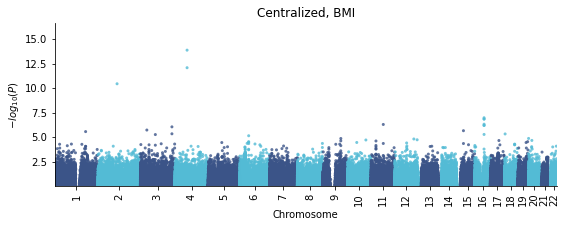

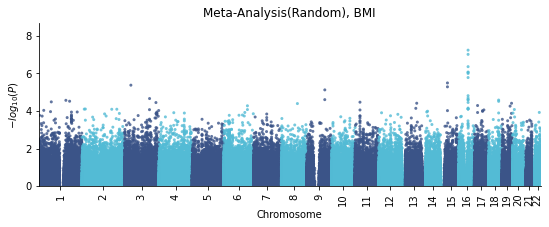

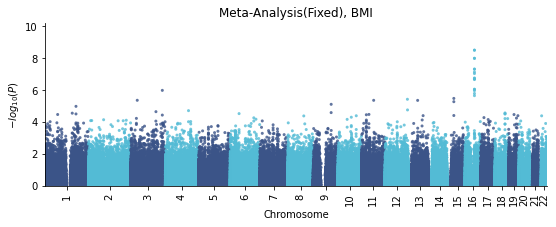

0.6217378182246137


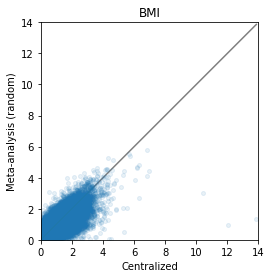

0.661042804639867


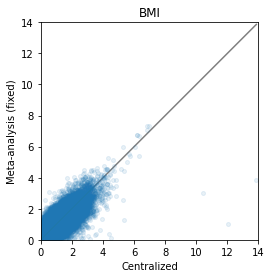

In [4]:
for phenoIndex in phenotypes:
    threshold = pow(10, -1*100)
    centralizedRes = centralizedResults[phenoIndex]
    metaRandomRes = metaRandomResults[phenoIndex]
    metaFixedRes = metaFixedResults[phenoIndex]
    
    # centralizedRes
    manhattanplot(data=centralizedRes[centralizedRes['P'] >= threshold],
        suggestiveline=None, # Turn off suggestive line
        genomewideline=None, # Turn off suggestive line
        marker = '.',
        xticklabel_kws={"rotation": "vertical"},  # set vertical or any other degrees as you like.
        title="Centralized, " + phenoIndex
        )
    plt.show()
    
     # Meta, random
    manhattanplot(data=metaRandomRes[metaRandomRes['P'] >= threshold],
        suggestiveline=None, # Turn off suggestive line
        genomewideline=None, # Turn off suggestive line
        marker = '.',
        xticklabel_kws={"rotation": "vertical"},  # set vertical or any other degrees as you like.
        title="Meta-Analysis(Random), " + phenoIndex 
        )
    plt.show()
    
    # Meta, fixed
    manhattanplot(data=metaFixedRes[metaFixedRes['P'] >= threshold],
        suggestiveline=None, # Turn off suggestive line
        genomewideline=None, # Turn off suggestive line
        marker = '.',
        xticklabel_kws={"rotation": "vertical"},  # set vertical or any other degrees as you like.
        title="Meta-Analysis(Fixed), " + phenoIndex
        )
    plt.show()
    
    
    # centralizedRes vs meta(random)
    centralizedRes['-logP'] = centralizedRes['LOG10P']
    centralizedRes = centralizedRes.replace([np.inf, -np.inf], np.nan)
    centralizedRes = centralizedRes.dropna(how="any", axis=0)

    metaRandomRes['P'] = pd.to_numeric(metaRandomRes.loc[:, 'P'])
    metaRandomRes['-logP'] = metaRandomRes.loc[:, 'P'].apply(np.log10)
    metaRandomRes.loc[:, '-logP'] = metaRandomRes.loc[:, '-logP'].apply(lambda x: x * -1)
    metaRandomRes = metaRandomRes.replace([np.inf, -np.inf], np.nan)
    metaRandomRes = metaRandomRes.dropna(how="any", axis=0)

    cent_meta_random = pd.merge(centralizedRes, metaRandomRes, how='inner', on=['#CHROM', 'POS', 'ID']) 
    print(np.corrcoef(cent_meta_random['-logP_x'].to_numpy(), cent_meta_random['-logP_y'].to_numpy())[0,1] ** 2)

    _, ax = plt.subplots()
    lims = [np.min([cent_meta_random['-logP_x'].min(), cent_meta_random['-logP_y'].min()]),  # min of both axes
            np.max([cent_meta_random['-logP_x'].max(), cent_meta_random['-logP_y'].max()]),  # max of both axes
            ]
    # plot both limits against eachother
    ax.plot(lims, lims, color="gray")
    plt.xlim(round(lims[0]), round(lims[1]))
    plt.ylim(round(lims[0]), round(lims[1]))
    ax.set_aspect('equal', adjustable='box')

    plt.xlabel("Centralized")
    plt.ylabel("Meta-analysis (random)")
    plt.title(phenoIndex)
    # plot markers
    plt.plot(cent_meta_random['-logP_x'], cent_meta_random['-logP_y'], 'o', alpha=0.1, markersize=4)
    plt.show()
    
    # centralizedRes vs meta(fixed)
    metaFixedRes['P'] = pd.to_numeric(metaFixedRes.loc[:, 'P'])
    metaFixedRes['-logP'] = metaFixedRes.loc[:, 'P'].apply(np.log10)
    metaFixedRes.loc[:, '-logP'] = metaFixedRes.loc[:, '-logP'].apply(lambda x: x * -1)
    metaFixedRes = metaFixedRes.replace([np.inf, -np.inf], np.nan)
    metaFixedRes = metaFixedRes.dropna(how="any", axis=0)

    cent_meta_fixed = pd.merge(centralizedRes, metaFixedRes, how='inner', on=['#CHROM', 'POS', 'ID']) 
    print(np.corrcoef(cent_meta_fixed['-logP_x'].to_numpy(), cent_meta_fixed['-logP_y'].to_numpy())[0,1] ** 2)

    _, ax = plt.subplots()
    lims = [np.min([cent_meta_fixed['-logP_x'].min(), cent_meta_fixed['-logP_y'].min()]),  # min of both axes
            np.max([cent_meta_fixed['-logP_x'].max(), cent_meta_fixed['-logP_y'].max()]),  # max of both axes
            ]


    # plot both limits against eachother
    ax.plot(lims, lims, color="gray")
    plt.xlim(round(lims[0]), round(lims[1]))
    plt.ylim(round(lims[0]), round(lims[1]))
    ax.set_aspect('equal', adjustable='box')

    plt.xlabel("Centralized")
    plt.ylabel("Meta-analysis (fixed)")
    plt.title(phenoIndex)

    # plot markers
    plt.plot(cent_meta_fixed['-logP_x'], cent_meta_fixed['-logP_y'], 'o', alpha=0.1, markersize=4)


    plt.show()